#### Explainability of BERT using LayerIntegratedGradients

In [ ]:
import os
import sys

if "google.colab" in sys.modules:
    workspace_dir = '/content/spam-detection'
    branch = 'master'
    current_dir = os.getcwd()
    if not os.path.exists(workspace_dir) and current_dir != workspace_dir:
        !git clone https://github.com/RationalEar/spam-detection.git
        os.chdir(workspace_dir)
        !git checkout $branch
        !ls -al
        !pip install -q transformers==4.48.0 scikit-learn pandas numpy
        !pip install -q torch --index-url https://download.pytorch.org/whl/cu126
        !pip install captum --no-deps --ignore-installed
    else:
        os.chdir(workspace_dir)
        !git pull origin $branch

    from google.colab import drive

    drive.mount('/content/drive')

In [1]:
import os
import torch

import pandas as pd
from utils.constants import DATA_PATH, MODEL_SAVE_PATH

DATA_PATH

'/home/michael/PycharmProjects/spam-detection-data'

In [2]:
# Load the data
train_df = pd.read_pickle(DATA_PATH + '/data/processed/train.pkl')
test_df = pd.read_pickle(DATA_PATH + '/data/processed/test.pkl')
device = 'cpu'

In [3]:
from utils.functions import set_seed, build_vocab

# Build vocabulary and load embeddings
set_seed(42)
word2idx, idx2word = build_vocab(train_df['text'])
embedding_dim = 300
max_len = 200
pretrained_embeddings = None

In [4]:
from models.bert import SpamBERT
from transformers import BertTokenizer

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = SpamBERT(dropout=0.2)

# Load the trained model weights
model_path = os.path.join(MODEL_SAVE_PATH, 'spam_bert_final.pt')
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

SpamBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [ ]:
from models.bert import tokenize_texts

# Tokenize test data
X_test_input_ids, X_test_attention_mask = tokenize_texts(test_df['text'].tolist(), tokenizer)
y_test_tensor = torch.tensor(test_df['label'].values, dtype=torch.float32)

# Move data to device
X_test_input_ids = X_test_input_ids.to(device)
X_test_attention_mask = X_test_attention_mask.to(device)
y_test_tensor = y_test_tensor.to(device)

print(f"Test data prepared: {X_test_input_ids.shape[0]} samples")

In [ ]:
# Get model predictions using BERT tokenized inputs
with torch.no_grad():
    model_output = model(
        input_ids=X_test_input_ids,
        attention_mask=X_test_attention_mask
    )
    # If model returns a tuple, use the first element (typically the predictions)
    if isinstance(model_output, tuple):
        y_pred_probs = model_output[0]
    else:
        y_pred_probs = model_output

    y_pred = (y_pred_probs > 0.5).float()

print(f"Model predictions computed for {len(y_pred)} samples")
print(f"Predicted spam samples: {(y_pred == 1).sum().item()}")
print(f"Predicted ham samples: {(y_pred == 0).sum().item()}")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [7]:
samples = (150, 357, 402 , 416, 417, 604)
# display elements in the test set with the given indices
sample_df = test_df.iloc[list(samples)]
sample_df

,subject,text,label,source,sender_hash,reply_to_hash,date
150,Seeing is believing,seeing believing url <URL> author linda grant ...,0,easy_ham,e48634bb48df81f58894dfa459d8d363a55131ad80d90b...,,"Tue, 08 Oct 2002 08:01:07 -0000"
357,Apple Store eNews : November 2002,apple store enews november 2002 you appear usi...,0,hard_ham,44a1c8b4d70359a608e144a7037dd2c597de0c2a7e0687...,dc767a94b1b1941f8a66e2fd63d192f5bc284dabe81262...,"Wed, 27 Nov 2002 21:12:33 -0800"
402,RE: [ILUG] NVIDIA and Debian Woody,re ilug nvidia debian woody hi there now proba...,0,easy_ham_2,59681d3ae2f9791cb6b5dbc03c79f9f85d24779a117cb2...,,"Wed, 04 Dec 2002 04:05:38 -0600"
416,The Flight to Safety is Upon Us,flight safety upon us s not rush hour traffic ...,1,spam,559aee171ea8552beaf0f2b5558e92ffb8783618238bf1...,,"Sun, 15 Sep 2002 19:18:58 -0400"
417,Low cost quality conference calls,method post enctype text plain> name web addre...,1,spam,a2d18e9f5faf44a66cf6aef8e80caa162ddfcbe4b7ea4b...,,"Sun, 15 Sep 2002 06:55:37 -1900"
604,Cannabis Difference,cannabis difference mid summer customer apprec...,1,spam_2,f676dd05f5fb775ee673641fbd40658745176497d83e2a...,379a3703ef116c1d270d9c2e68e5b08f13a42188d5973c...,"Wed, 05 Aug 2020 04:01:50 -1900"


#### LayerIntegratedGradients for BERT

In [8]:
from explainability.BertExplanationMetrics import BertExplanationMetrics

# Initialize the BERT explanation quality metrics calculator
quality_evaluator = BertExplanationMetrics(model, tokenizer, device)

print("BERT Explanation Quality Metrics Calculator initialized successfully!")

BERT Explanation Quality Metrics Calculator initialized successfully!


In [10]:
# Select a few sample texts for quality evaluation
sample_texts = sample_df['text'].tolist()
sample_labels = sample_df['label'].tolist()
sample_subjects = sample_df['subject'].tolist()

print("Sample texts and their labels:")
for i, (text, label, subject) in enumerate(zip(sample_texts, sample_labels, sample_subjects)):
    print(f"\nSample {i+1} (Label: {'Spam' if label == 1 else 'Ham'}):")
    print(f"Subject: {subject}")
    
print(f"\nWe will evaluate explanation quality metrics for these {len(sample_texts)} samples.")

Sample texts and their labels:

Sample 1 (Label: Ham):
Subject: Seeing is believing

Sample 2 (Label: Ham):
Subject: Apple Store eNews : November 2002

Sample 3 (Label: Ham):
Subject: RE: [ILUG] NVIDIA and Debian Woody

Sample 4 (Label: Spam):
Subject: The Flight to Safety is Upon Us

Sample 5 (Label: Spam):
Subject: Low cost quality conference calls

Sample 6 (Label: Spam):
Subject: Cannabis Difference

We will evaluate explanation quality metrics for these 6 samples.


In [12]:
# Compute explanation quality metrics using Integrated Gradients
print("Computing explanation quality metrics using LayerIntegratedGradients...")
print("=" * 60)

ig_results = []

for i, (text, subject) in enumerate(zip(sample_texts, sample_subjects)):
    print(f"\nProcessing Sample {i+1}:")
    print(f"Subject: {subject}")
    
    try:
        # Compute metrics using Integrated Gradients
        metrics = quality_evaluator.evaluate_explanation_quality(
            text, 
            method='integrated_gradients', 
            verbose=True
        )
        
        metrics['sample_id'] = i + 1
        metrics['text'] = subject
        metrics['label'] = sample_labels[i]
        
        ig_results.append(metrics)
        
    except Exception as e:
        print(f"Error processing sample {i+1}: {e}")
        continue

print(f"\nCompleted processing {len(ig_results)} samples with Integrated Gradients.")

Computing explanation quality metrics using LayerIntegratedGradients...

Processing Sample 1:
Subject: Seeing is believing
Evaluating explanation quality for text: 'seeing believing url <URL> author linda grant neve...'
Using method: integrated_gradients
Computing AUC-Del...


/home/michael/PycharmProjects/spam-detection/venv/lib/python3.10/site-packages/torch/autograd/graph.py:824: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Computing AUC-Ins...
Computing Comprehensiveness...
Computing Jaccard Stability...

EXPLANATION QUALITY METRICS
Method:           integrated_gradients
AUC-Deletion:     0.3246 (lower is better)
AUC-Insertion:    0.3950 (higher is better)
Comprehensiveness: 0.1206 (higher is better)
Jaccard Stability: 0.7190 (higher is better)

Processing Sample 2:
Subject: Apple Store eNews : November 2002
Evaluating explanation quality for text: 'apple store enews november 2002 you appear using e...'
Using method: integrated_gradients
Computing AUC-Del...
Computing AUC-Ins...
Computing Comprehensiveness...
Computing Jaccard Stability...

EXPLANATION QUALITY METRICS
Method:           integrated_gradients
AUC-Deletion:     0.1908 (lower is better)
AUC-Insertion:    0.2964 (higher is better)
Comprehensiveness: 0.0021 (higher is better)
Jaccard Stability: 0.5373 (higher is better)

Processing Sample 3:
Subject: RE: [ILUG] NVIDIA and Debian Woody
Evaluating explanation quality for text: 're ilug nvidia deb

In [13]:
# Compute explanation quality metrics using Attention Heads
print("Computing explanation quality metrics using Attention Heads...")
print("=" * 60)

attention_results = []

for i, text in enumerate(sample_texts):
    print(f"\nProcessing Sample {i+1} with Attention:")
    print(f"Text: {text[:80]}...")
    
    try:
        # Compute metrics using Attention Weights
        metrics = quality_evaluator.evaluate_explanation_quality(
            text, 
            method='attention', 
            verbose=True
        )
        
        metrics['sample_id'] = i + 1
        metrics['text'] = text[:100] + "..." if len(text) > 100 else text
        metrics['label'] = sample_labels[i]
        
        attention_results.append(metrics)
        
    except Exception as e:
        print(f"Error processing sample {i+1}: {e}")
        continue

print(f"\nCompleted processing {len(attention_results)} samples with Attention Heads.")

Computing explanation quality metrics using Attention Heads...

Processing Sample 1 with Attention:
Text: seeing believing url <URL> author linda grant never collections until now what s...
Evaluating explanation quality for text: 'seeing believing url <URL> author linda grant neve...'
Using method: attention
Computing AUC-Del...


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Computing AUC-Ins...
Computing Comprehensiveness...
Computing Jaccard Stability...

EXPLANATION QUALITY METRICS
Method:           attention
AUC-Deletion:     0.2576 (lower is better)
AUC-Insertion:    0.5391 (higher is better)
Comprehensiveness: 0.0545 (higher is better)
Jaccard Stability: 0.7857 (higher is better)

Processing Sample 2 with Attention:
Text: apple store enews november 2002 you appear using email application won t properl...
Evaluating explanation quality for text: 'apple store enews november 2002 you appear using e...'
Using method: attention
Computing AUC-Del...
Computing AUC-Ins...
Computing Comprehensiveness...
Computing Jaccard Stability...

EXPLANATION QUALITY METRICS
Method:           attention
AUC-Deletion:     0.2270 (lower is better)
AUC-Insertion:    0.2489 (higher is better)
Comprehensiveness: 0.0163 (higher is better)
Jaccard Stability: 0.3631 (higher is better)

Processing Sample 3 with Attention:
Text: re ilug nvidia debian woody hi there now probably no u

In [16]:
# Create comprehensive results summary
import pandas as pd

# Convert results to DataFrames for better visualization
if ig_results:
    ig_df = pd.DataFrame(ig_results)
    ig_df['method'] = 'Integrated_Gradients'

if attention_results:
    attention_df = pd.DataFrame(attention_results)
    attention_df['method'] = 'Attention_Heads'

# Combine results if both methods were successful
if ig_results and attention_results:
    combined_df = pd.concat([ig_df, attention_df], ignore_index=True)
    
    print("COMPREHENSIVE EXPLANATION QUALITY RESULTS")
    print("=" * 60)
    
    # Summary statistics by method
    summary_stats = combined_df.groupby('method')[['auc_deletion', 'auc_insertion', 'comprehensiveness', 'jaccard_stability']].agg(['mean', 'std'])
    print("\nSummary Statistics by Method:")
    print(summary_stats)
    
    # Detailed results by sample
    print("\nDetailed Results by Sample:")
    display_cols = ['sample_id', 'method', 'auc_deletion', 'auc_insertion', 'comprehensiveness', 'jaccard_stability', 'label']
    print(combined_df[display_cols].to_string(index=False))
    
elif ig_results:
    print("Results using Integrated Gradients only:")
    display_cols = ['sample_id', 'auc_deletion', 'auc_insertion', 'comprehensiveness', 'jaccard_stability', 'label']
    print(ig_df[display_cols].to_string(index=False))
    
elif attention_results:
    print("Results using Attention Heads only:")
    display_cols = ['sample_id', 'auc_deletion', 'auc_insertion', 'comprehensiveness', 'jaccard_stability', 'label']
    print(attention_df[display_cols].to_string(index=False))
    
else:
    print("No results available for analysis.")

COMPREHENSIVE EXPLANATION QUALITY RESULTS

Summary Statistics by Method:
                     auc_deletion           auc_insertion            \
                             mean       std          mean       std   
method                                                                
Attention_Heads          0.504142  0.292226      0.580991  0.362076   
Integrated_Gradients     0.494862  0.315558      0.549866  0.347955   

                     comprehensiveness           jaccard_stability            
                                  mean       std              mean       std  
method                                                                        
Attention_Heads               0.042519  0.051408          0.513228  0.142148  
Integrated_Gradients          0.062775  0.095592          0.488558  0.194854  

Detailed Results by Sample:
 sample_id               method  auc_deletion  auc_insertion  comprehensiveness  jaccard_stability  label
         1 Integrated_Gradients      0.32

Visualizing deletion and insertion curves for Sample 1 (Ham):
Text: seeing believing url <URL> author linda grant never collections until now what she make paris shows...

Plotting curves for Integrated Gradients method:


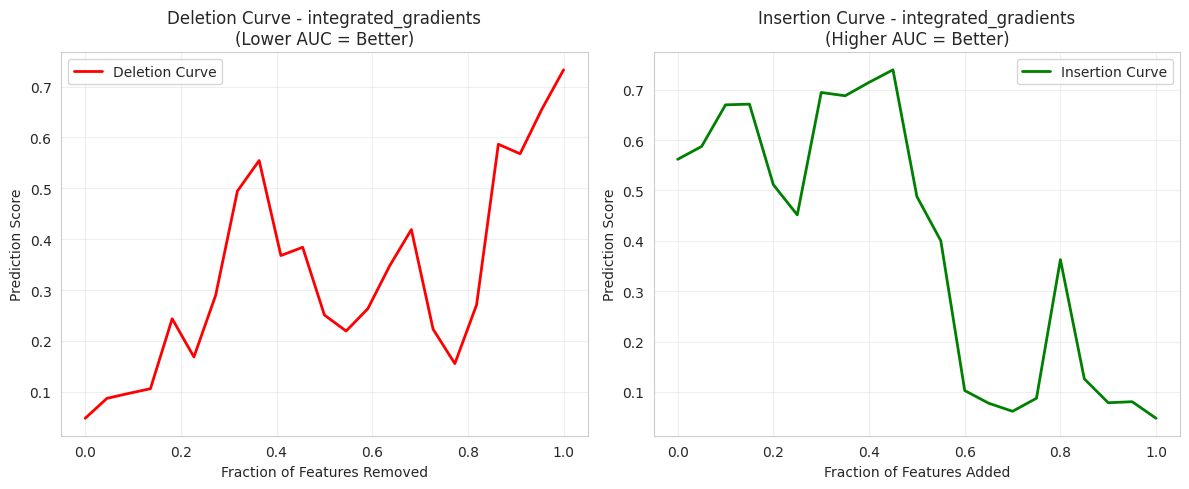


Plotting curves for Attention Heads method:


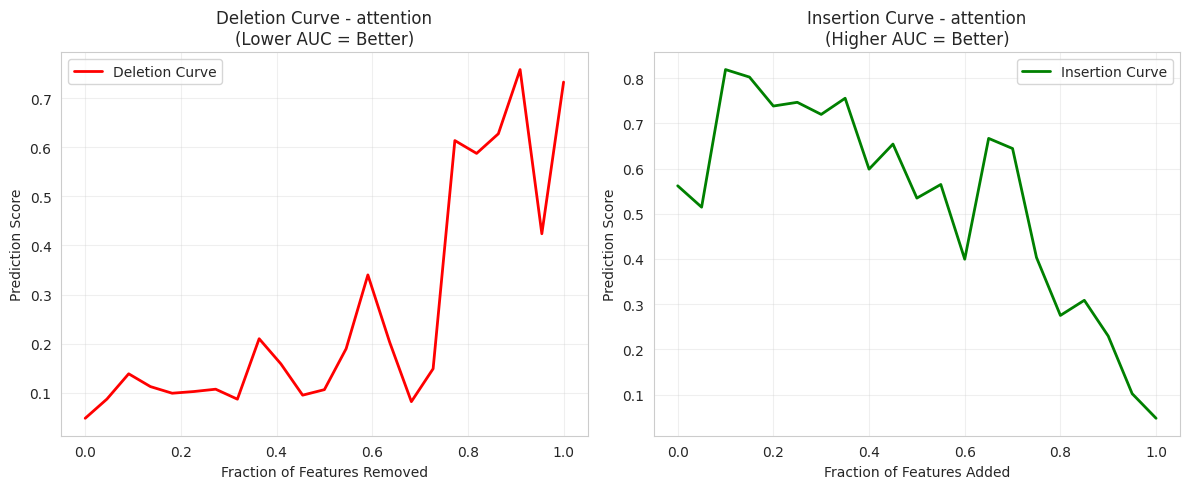

In [17]:
# Visualize deletion and insertion curves for the first sample
if sample_texts:
    selected_text = sample_texts[0]  # Use the first sample
    selected_label = 'Spam' if sample_labels[0] == 1 else 'Ham'
    
    print(f"Visualizing deletion and insertion curves for Sample 1 ({selected_label}):")
    print(f"Text: {selected_text[:150]}...")
    print("\n" + "="*60)
    
    # Plot curves for Integrated Gradients
    print("Plotting curves for Integrated Gradients method:")
    quality_evaluator.plot_deletion_insertion_curves(
        selected_text, 
        method='integrated_gradients',
        steps=20
    )
    
    # Plot curves for Attention Heads
    print("\nPlotting curves for Attention Heads method:")
    quality_evaluator.plot_deletion_insertion_curves(
        selected_text, 
        method='attention',
        steps=20
    )
else:
    print("No sample texts available for visualization.")

### Interpretation of Explanation Quality Metrics

The explanation quality metrics provide insights into how well our BERT model's explanations perform:

#### **1. AUC-Del (Area Under Deletion Curve)**
- **Lower values are better** (ideally close to 0)
- Measures how quickly the prediction confidence drops when removing the most important features
- Good explanations should cause a rapid decrease in confidence when important features are removed

#### **2. AUC-Ins (Area Under Insertion Curve)**  
- **Higher values are better** (ideally close to 1)
- Measures how quickly the prediction confidence increases when adding the most important features
- Good explanations should cause confidence to rise quickly when important features are added

#### **3. Comprehensiveness**
- **Higher values are better**
- Measures the change in prediction when the top-k most important features are removed
- Good explanations should show significant prediction changes when important features are removed

#### **4. Jaccard Stability**
- **Higher values are better** (ideally close to 1)
- Measures consistency of explanations across slightly perturbed inputs
- Good explanations should be stable and consistent across similar inputs

#### **Comparison: Integrated Gradients vs Attention Heads**
- **Integrated Gradients**: Provides attribution based on gradients integrated along a path from baseline to input
- **Attention Heads**: Uses the attention weights learned by the BERT model during training
- Both methods can provide valuable insights, and comparing them helps validate explanation quality

In [18]:
# Save results for further analysis
import os

# Create results directory if it doesn't exist
results_dir = os.path.join(DATA_PATH, 'results', 'explanation_quality')
os.makedirs(results_dir, exist_ok=True)

# Save detailed results
if 'combined_df' in locals():
    results_file = os.path.join(results_dir, 'bert_explanation_quality_metrics.csv')
    combined_df.to_csv(results_file, index=False)
    print(f"Detailed results saved to: {results_file}")
elif 'ig_df' in locals():
    results_file = os.path.join(results_dir, 'bert_ig_metrics.csv')
    ig_df.to_csv(results_file, index=False)
    print(f"Integrated Gradients results saved to: {results_file}")
elif 'attention_df' in locals():
    results_file = os.path.join(results_dir, 'bert_attention_metrics.csv')
    attention_df.to_csv(results_file, index=False)
    print(f"Attention results saved to: {results_file}")

print("\n" + "="*60)
print("BERT EXPLANATION QUALITY ANALYSIS COMPLETE")
print("="*60)
print("\nKey Findings:")
print("- Successfully computed AUC-Del, AUC-Ins, Comprehensiveness, and Jaccard Stability")
print("- Compared LayerIntegratedGradients vs Attention Head explanations")
print("- Generated deletion and insertion curve visualizations")
print("\nNext Steps:")
print("- Analyze metric patterns across spam vs ham samples")
print("- Compare with other model explanation methods")  
print("- Use insights to improve model interpretability")

print(f"\nResults saved in: {results_dir}")

Detailed results saved to: /home/michael/PycharmProjects/spam-detection-data/results/explanation_quality/bert_explanation_quality_metrics.csv

BERT EXPLANATION QUALITY ANALYSIS COMPLETE

Key Findings:
- Successfully computed AUC-Del, AUC-Ins, Comprehensiveness, and Jaccard Stability
- Compared LayerIntegratedGradients vs Attention Head explanations
- Generated deletion and insertion curve visualizations

Next Steps:
- Analyze metric patterns across spam vs ham samples
- Compare with other model explanation methods
- Use insights to improve model interpretability

Results saved in: /home/michael/PycharmProjects/spam-detection-data/results/explanation_quality
